# STEAM Project: big data module

The following analysis is being done as a mandatory project for certification bloc 2 (Machine Learning Engineer at Jedha).

In the scope of the project: 
  - use of Databricks and PySpark to conduct an EDA, 
  - use of Databrick's visualisation tool to create visualizations to publish findings for easy review

The notebook is organized in the followings steps:

1. Data retrieval from a given S3 bucket
2. Cleaning and structuring the data using PySpark’s DataFrames.
3. Breaking down the analysis into macro-level, genre-level, and platform-level trends using aggregations and groupBy.

In [0]:
# Initializing PySpark

from pyspark.sql import SparkSession

# Starting Spark session
spark = SparkSession.builder.appName("Steam_EDA").getOrCreate()

# Loading the given data in Databricks (JSON file)
steam_df = spark.read.json("s3://full-stack-bigdata-datasets/Big_Data/Project_Steam/steam_game_output.json")

# Showing schema
steam_df.printSchema()

root
 |-- data: struct (nullable = true)
 |    |-- appid: long (nullable = true)
 |    |-- categories: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- ccu: long (nullable = true)
 |    |-- developer: string (nullable = true)
 |    |-- discount: string (nullable = true)
 |    |-- genre: string (nullable = true)
 |    |-- header_image: string (nullable = true)
 |    |-- initialprice: string (nullable = true)
 |    |-- languages: string (nullable = true)
 |    |-- name: string (nullable = true)
 |    |-- negative: long (nullable = true)
 |    |-- owners: string (nullable = true)
 |    |-- platforms: struct (nullable = true)
 |    |    |-- linux: boolean (nullable = true)
 |    |    |-- mac: boolean (nullable = true)
 |    |    |-- windows: boolean (nullable = true)
 |    |-- positive: long (nullable = true)
 |    |-- price: string (nullable = true)
 |    |-- publisher: string (nullable = true)
 |    |-- release_date: string (nullable = true)
 |    |-

In [0]:
# Displaying sample data
steam_df.show(5)

+--------------------+-------+
|                data|     id|
+--------------------+-------+
|{10, [Multi-playe...|     10|
|{1000000, [Single...|1000000|
|{1000010, [Single...|1000010|
|{1000030, [Multi-...|1000030|
|{1000040, [Single...|1000040|
+--------------------+-------+
only showing top 5 rows



# Initial structure of the Steam dataset

The dataset contains two columns:
- 'id': unique identifier for each game (Steam App ID)
- 'data': a nested struct with all game metadata

The 'data' column is a 'struct', an object with multiple attributes, that includes:

- Basic info: name, genre, publisher, release_date
- Pricing: initial_price, discount, current_price
- Popularity: owners (estimated range), review counts
- Platform support: Windows, Mac, Linux
- Categories: array of gameplay modes (e.g. Single-player, Multiplayer)
- Tags: hundreds of binary indicators for game features and themes

This nested structure requires flattening or selective extraction before performing any meaningful analysis (e.g. genre trends, revenue estimates)


In [0]:
# Starting to explore the data

steam_df.select("data.name", "data.genre", "data.publisher", "data.price").display(10, truncate=True)

name,genre,publisher,price
Counter-Strike,Action,Valve,999
ASCENXION,"Action, Adventure, Indie",PsychoFlux Entertainment,999
Crown Trick,"Adventure, Indie, RPG, Strategy","Team17, NEXT Studios",599
"Cook, Serve, Delicious! 3?!","Action, Indie, Simulation, Strategy",Vertigo Gaming Inc.,1999
细胞战争,"Action, Casual, Indie, Simulation",DoubleC Games,199
Zengeon,"Action, Adventure, Indie, RPG",2P Games,799
干支セトラ 陽ノ卷｜干支etc. 陽之卷,"Adventure, Indie, RPG, Strategy",Starship Studio,1299
Jumping Master(跳跳大咖),"Action, Adventure, Casual, Free to Play, Massively Multiplayer",重庆环游者网络科技,0
Cube Defender,"Casual, Indie",Simon Codrington,299
Tower of Origin2-Worm's Nest,"Indie, RPG",Villain Role,1399


In [0]:
from pyspark.sql.functions import col

# Extracting key price related attributes
steam_df = steam_df.withColumn("initial_price", col("data.initialprice"))
steam_df = steam_df.withColumn("discount", col("data.discount"))
steam_df = steam_df.withColumn("current_price", col("data.price"))

# Drop the original columns (optional)
steam_df = steam_df.drop("data.initialprice", "data.discount", "data.price")

# Show results
steam_df.select("initial_price", "discount", "current_price").show(10)

+-------------+--------+-------------+
|initial_price|discount|current_price|
+-------------+--------+-------------+
|          999|       0|          999|
|          999|       0|          999|
|         1999|      70|          599|
|         1999|       0|         1999|
|          199|       0|          199|
|         1999|      60|          799|
|         1299|       0|         1299|
|            0|       0|            0|
|          299|       0|          299|
|         1399|       0|         1399|
+-------------+--------+-------------+
only showing top 10 rows


The above prices extraction shows that they are expressed in cents which doesn't give a clear view on the games' value. In the below analysis, this point is being handled: the indicated prices shall be divided by 100 so that the analysis gives a realistic output.

In PySpark, .cast("double") is used to convert a column's data type to a double-precision floating-point number — essentially, a numeric type that can handle decimals.

We may use it to: 
    * To perform numeric operations like addition, multiplication, or averaging.
    * To ensure compatibility with functions like sum(), avg(), or round().
    * To convert strings like "1999" (representing cents) into 19.99 after dividing by 100.

In [0]:
from pyspark.sql.functions import format_number

# Convert prices and discount to numeric before rounding
steam_df = steam_df.withColumn("initial_price", col("initial_price").cast("double") / 100)
steam_df = steam_df.withColumn("discount", col("discount").cast("double") / 100)
steam_df = steam_df.withColumn("current_price", col("initial_price") * (1 - col("discount")))

# Format to 2 decimal places
steam_df = steam_df.withColumn("initial_price", format_number(col("initial_price"), 2))
steam_df = steam_df.withColumn("discount", format_number(col("discount"), 2))
steam_df = steam_df.withColumn("current_price", format_number(col("current_price"), 2))

# Display results
steam_df.select("initial_price", "discount", "current_price").show(10)

+-------------+--------+-------------+
|initial_price|discount|current_price|
+-------------+--------+-------------+
|         9.99|    0.00|         9.99|
|         9.99|    0.00|         9.99|
|        19.99|    0.70|         6.00|
|        19.99|    0.00|        19.99|
|         1.99|    0.00|         1.99|
|        19.99|    0.60|         8.00|
|        12.99|    0.00|        12.99|
|         0.00|    0.00|         0.00|
|         2.99|    0.00|         2.99|
|        13.99|    0.00|        13.99|
+-------------+--------+-------------+
only showing top 10 rows


In [0]:
from pyspark.sql.functions import explode

# Flattening arrays into rows (using explode()): 'category' attribute is an array so this method is suitable to make it more analyzable

steam_df = steam_df.withColumn("category", explode(col("data.categories")))

# Drop the original array column
steam_df = steam_df.drop("data.categories")

steam_df.show(10)

+--------------------+-------+-------------+--------+-------------+--------------------+
|                data|     id|initial_price|discount|current_price|            category|
+--------------------+-------+-------------+--------+-------------+--------------------+
|{10, [Multi-playe...|     10|         9.99|    0.00|         9.99|        Multi-player|
|{10, [Multi-playe...|     10|         9.99|    0.00|         9.99|Valve Anti-Cheat ...|
|{10, [Multi-playe...|     10|         9.99|    0.00|         9.99|          Online PvP|
|{10, [Multi-playe...|     10|         9.99|    0.00|         9.99|Shared/Split Scre...|
|{10, [Multi-playe...|     10|         9.99|    0.00|         9.99|                 PvP|
|{1000000, [Single...|1000000|         9.99|    0.00|         9.99|       Single-player|
|{1000000, [Single...|1000000|         9.99|    0.00|         9.99|Partial Controlle...|
|{1000000, [Single...|1000000|         9.99|    0.00|         9.99|  Steam Achievements|
|{1000000, [Single...

In [0]:
from pyspark.sql.functions import count, when

# Handling missing values and data cleanup
# Count missing values per column
steam_df.select([count(when(col(c).isNull(), c)).alias(c) for c in steam_df.columns]).show()

+----+---+-------------+--------+-------------+--------+
|data| id|initial_price|discount|current_price|category|
+----+---+-------------+--------+-------------+--------+
|   0|  0|            0|       0|            0|       0|
+----+---+-------------+--------+-------------+--------+



The missing value check is not detecting any missing values/blanks correctly. The reasons for that might be diverse so the analysis shall be deepened to explore a little more if the missing values exist (for example: struct & nested fields may be masking nulls → if a field is inside a struct, PySpark may not detect nulls directly.)

In [0]:
# Check for missing values in individual fields inside the struct
steam_df.select([
    count(when(col("data.name").isNull(), "data.name")).alias("name_missing"),
    count(when(col("data.genre").isNull(), "data.genre")).alias("genre_missing"),
    count(when(col("data.publisher").isNull(), "data.publisher")).alias("publisher_missing"),
    count(when(col("data.price").isNull(), "data.price")).alias("price_missing")
]).show()

+------------+-------------+-----------------+-------------+
|name_missing|genre_missing|publisher_missing|price_missing|
+------------+-------------+-----------------+-------------+
|           0|            0|                0|            0|
+------------+-------------+-----------------+-------------+



It looks like the dataset doesn't display any missing values in the above columns so we may proceed with further analysis.

In [0]:
from pyspark.sql.functions import countDistinct

# Checking the distinct number of values in columns
steam_df.select([countDistinct(col(c)).alias(c) for c in steam_df.columns]).show()

+-----+-----+-------------+--------+-------------+--------+
| data|   id|initial_price|discount|current_price|category|
+-----+-----+-------------+--------+-------------+--------+
|54721|54721|          191|      63|          411|      36|
+-----+-----+-------------+--------+-------------+--------+



Interpretation of the above results:
- The data struct has 54,721 unique entries, meaning there are 54,721 different games in the dataset.
- Since every game should have a unique ID, this confirms there are 54,721 distinct games—no duplicates in id.
- This means the dataset contains 191 different price points before discounts. Some games may have the same initial price.
- There are 63 unique discount values across all games, meaning Steam applies a variety of discount percentages.
- There are 411 different final prices after discounts are applied—suggesting a mix of pricing strategies.
- The category column has only 36 unique values, meaning there are 36 different game categories/types (e.g., Single-player, Multiplayer, VR, etc.).

The dataset seems clean and structured—no obvious duplication of id values. Pricing distribution is varied (with 191 initial price points and 411 final price values). Discounting strategy is diverse, but limited to 63 different discount percentages. Categories are well-defined, as there are only 36 unique game types.

Since there are no single-value columns (everything has multiple unique entries), it looks like this dataset wasn’t artificially filled with default values. This suggests missing values might have been handled before the dataset was created, rather than appearing as NULL entries. The Exploratory Data Analysis may now be conducted - we shall follow the guidelines given for this project. The analysis will be done in 3 parts:
- the "macro" level analysis
- the genre analysis
- the platform analysis
Each of these seeks to answer the given questions which will be done respectively

# EDA part 1: "Macro" level analysis

The below part is dedicated to a 'big picture' view of the Steam platform itself. We will be looking at game publishers, best rated games, historical trends of releases, prices distribution etc. 

In [0]:
# Which publisher has released the most games on Steam?

# Count number of games per publisher
publisher_count_df = steam_df.groupBy("data.publisher").agg(count("id").alias("game_count"))

# Sort publishers by game count (descending order)
publisher_count_df.orderBy(col("game_count").desc()).show(10)

+--------------------+----------+
|           publisher|game_count|
+--------------------+----------+
|                SEGA|       829|
|         Square Enix|       654|
|          THQ Nordic|       628|
|    Devolver Digital|       603|
|BANDAI NAMCO Ente...|       579|
|     Electronic Arts|       513|
|     Choice of Games|       503|
|             Ubisoft|       487|
|               Nacon|       459|
|      Big Fish Games|       457|
+--------------------+----------+
only showing top 10 rows


In [0]:
# Visualizing the list of Top 10 publishers with Databricks Visualization

# Count games per publisher
publisher_df = steam_df.groupBy("data.publisher").agg(
    count("*").alias("game_count")
)

# Select top 10 publishers
top_publishers_df = publisher_df.orderBy(col("game_count").desc()).limit(10)

# Display bar chart in Databricks
display(top_publishers_df)

publisher,game_count
SEGA,829
Square Enix,654
THQ Nordic,628
Devolver Digital,603
BANDAI NAMCO Entertainment,579
Electronic Arts,513
Choice of Games,503
Ubisoft,487
Nacon,459
Big Fish Games,457


Databricks visualization. Run in Databricks to view.

In [0]:
# What are the best rated games?

# Compute Total Reviews (the sum of positive and negative reviews)
steam_df = steam_df.withColumn(
    "total_reviews", col("data.positive") + col("data.negative")
)

# Compute Positive Ratio (Percentage of Positive Reviews)

from pyspark.sql.functions import col, when, round as spark_round

steam_df = steam_df.withColumn(
    "positive_ratio",
    when(
        col("total_reviews") > 0, # avoiding division by zero
        spark_round((col("data.positive") / col("total_reviews")) * 100, 2)
    ).otherwise(None)
)

# Filter Out Games With Very Few Ratings (e.g., Less Than 50000)
steam_df_filtered = steam_df.filter(col("total_reviews") >= 50000)

# Sort by Positive Ratio
top_rated_games_df = steam_df_filtered.select("id", "data.name", "data.publisher", "positive_ratio", "total_reviews")\
    .orderBy(col("positive_ratio").desc()) 

# Display Full Results Without Truncation
display(top_rated_games_df)

id,name,publisher,positive_ratio,total_reviews
1118200,People Playground,Studio Minus,98.86,144569
1118200,People Playground,Studio Minus,98.86,144569
1118200,People Playground,Studio Minus,98.86,144569
1118200,People Playground,Studio Minus,98.86,144569
1118200,People Playground,Studio Minus,98.86,144569
620,Portal 2,Valve,98.78,309441
620,Portal 2,Valve,98.78,309441
620,Portal 2,Valve,98.78,309441
620,Portal 2,Valve,98.78,309441
620,Portal 2,Valve,98.78,309441


In [0]:
# Displaying top 10 games/titles with the highest positive ratio

top_10_games_df = top_rated_games_df.orderBy(col("positive_ratio").desc())\
                                    .dropDuplicates(["id"])\
                                    .limit(10)
display(top_10_games_df )

id,name,publisher,positive_ratio,total_reviews
1118200,People Playground,Studio Minus,98.86,144569
620,Portal 2,Valve,98.78,309441
1794680,Vampire Survivors,poncle,98.77,131935
1145360,Hades,Supergiant Games,98.6,202789
400,Portal,Valve,98.46,113538
546560,Half-Life: Alyx,Valve,98.46,75098
460950,Katana ZERO,Devolver Digital,98.25,50114
294100,RimWorld,Ludeon Studios,98.24,144751
413150,Stardew Valley,ConcernedApe,98.17,506841
431960,Wallpaper Engine,Wallpaper Engine Team,98.07,572127


In [0]:
# Convert to Pandas for Visualization
top_10_games_pd = top_10_games_df.select("name", "positive_ratio").toPandas()

In [0]:
display(top_10_games_pd)

name,positive_ratio
People Playground,98.86
Portal 2,98.78
Vampire Survivors,98.77
Hades,98.6
Portal,98.46
Half-Life: Alyx,98.46
Katana ZERO,98.25
RimWorld,98.24
Stardew Valley,98.17
Wallpaper Engine,98.07


Databricks visualization. Run in Databricks to view.

In [0]:
# Let's look at the historical trends of the releases. Are there years with more releases?

from pyspark.sql.functions import substring

# Extract year directly from the raw release date
steam_df = steam_df.withColumn("release_year", substring(col("data.release_date"), 1, 4))

# Show sample results
steam_df.select("data.name", "data.release_date", "release_year").show(20, truncate=False)

+---------------------------+------------+------------+
|name                       |release_date|release_year|
+---------------------------+------------+------------+
|Counter-Strike             |2000/11/1   |2000        |
|Counter-Strike             |2000/11/1   |2000        |
|Counter-Strike             |2000/11/1   |2000        |
|Counter-Strike             |2000/11/1   |2000        |
|Counter-Strike             |2000/11/1   |2000        |
|ASCENXION                  |2021/05/14  |2021        |
|ASCENXION                  |2021/05/14  |2021        |
|ASCENXION                  |2021/05/14  |2021        |
|ASCENXION                  |2021/05/14  |2021        |
|Crown Trick                |2020/10/16  |2020        |
|Crown Trick                |2020/10/16  |2020        |
|Crown Trick                |2020/10/16  |2020        |
|Crown Trick                |2020/10/16  |2020        |
|Crown Trick                |2020/10/16  |2020        |
|Cook, Serve, Delicious! 3?!|2020/10/14  |2020  

In [0]:
# Count games based on unique game IDs
unique_game_df = steam_df.select("id", "release_year").distinct()  # Ensure each game appears only once

# Count releases per year based on unique games
release_trend_df = unique_game_df.groupBy("release_year").agg(count("id").alias("game_count"))

# Sort results
release_trend_df = release_trend_df.orderBy(col("release_year").desc())
release_trend_df.orderBy(col("release_year").desc()).show(20)

+------------+----------+
|release_year|game_count|
+------------+----------+
|        2022|      7404|
|        2021|      8694|
|        2020|      8173|
|        2019|      6816|
|        2018|      7523|
|        2017|      5856|
|        2016|      4096|
|        2015|      2532|
|        2014|      1531|
|        2013|       464|
|        2012|       342|
|        2011|       266|
|        2010|       287|
|        2009|       311|
|        2008|       158|
|        2007|        97|
|        2006|        61|
|        2005|         6|
|        2004|         6|
|        2003|         3|
+------------+----------+
only showing top 20 rows


In [0]:
# Visualizing the "Historical Trend of Game Releases on Steam"
display(release_trend_df)

release_year,game_count
2022,7404
2021,8694
2020,8173
2019,6816
2018,7523
2017,5856
2016,4096
2015,2532
2014,1531
2013,464


Databricks visualization. Run in Databricks to view.

Let's zoom a little at the "COVID-19" period, ie years 2019-2021. During this time the economy and also the game market were in a very unusual situation: because of the worldwide pandemics, most of the countries introduced lockdowns and curfews. This means that people stayed at home in order to avoid the spread of the disease, new working habits were installed (home-office), but also home entertainment (games included) gained even more popularity. Let's see if the numbers confirm that statement.

In [0]:
# Were there more or fewer game releases during the Covid period (between 2019 and 2021)?
 
from pyspark.sql.functions import col, when

release_trend_df = release_trend_df.withColumn(
    "release_year",
    when(
        (col("release_year") == "") | (col("release_year").isNull()),
        None
    ).otherwise(col("release_year").cast("bigint"))
)

release_trend_df.filter(col("release_year").between(2019, 2021)).orderBy(col("release_year").asc()).show()

+------------+----------+
|release_year|game_count|
+------------+----------+
|        2019|      6816|
|        2020|      8173|
|        2021|      8694|
+------------+----------+



In [0]:
covid_trend_df=release_trend_df.filter(col("release_year").between(2019, 2021)).orderBy(col("release_year").asc())
display(covid_trend_df)

release_year,game_count
2019,6816
2020,8173
2021,8694


Databricks visualization. Run in Databricks to view.

Conclusion: the a/m numbers and visualizations confirm clearly that the Covid period was a growth period for gaming. 

In [0]:
# How are the prices distributed? 

from pyspark.sql.functions import min, max, avg

# Convert current_price to numeric
steam_df = steam_df.withColumn("current_price", col("current_price").cast("double"))

# Compute basic price stats
price_stats_df = steam_df.select(
    min(col("current_price")).alias("min_price"),
    max(col("current_price")).alias("max_price"),
    avg(col("current_price")).alias("avg_price")
)

# Compute percentiles
price_percentiles = steam_df.approxQuantile("current_price", [0.25, 0.5, 0.75], 0.01)

# Convert to Pandas for better readability
price_stats_pd = price_stats_df.toPandas()
price_stats_pd["25th_percentile"] = price_percentiles[0]
price_stats_pd["median_price"] = price_percentiles[1]
price_stats_pd["75th_percentile"] = price_percentiles[2]

# Display basic stats
display(price_stats_pd)

min_price,max_price,avg_price,25th_percentile,median_price,75th_percentile
0.0,999.0,9.095825377738581,1.99,5.99,12.99


In [0]:
# Looking closer at the prices distribution:

# Define Price Ranges
steam_df = steam_df.withColumn(
    "price_range",
    when(col("current_price") < 5, "Under $5")
    .when((col("current_price") >= 5) & (col("current_price") < 10), "$5 - $10")
    .when((col("current_price") >= 10) & (col("current_price") < 20), "$10 - $20")
    .when((col("current_price") >= 20) & (col("current_price") < 50), "$20 - $50")
    .when((col("current_price") >= 50) & (col("current_price") < 100), "$50 - $100")
    .otherwise("Over $100")
)

# Count Unique Games Per Price Range
price_distribution_df = steam_df.groupBy("price_range").agg(countDistinct("id").alias("game_count"))

# Ensure Correct Sorting Order
price_distribution_df = price_distribution_df.withColumn(
    "sort_order",
    when(col("price_range") == "Under $5", 1)
    .when(col("price_range") == "$5 - $10", 2)
    .when(col("price_range") == "$10 - $20", 3)
    .when(col("price_range") == "$20 - $50", 4)
    .when(col("price_range") == "$50 - $100", 5)
    .otherwise(6)  # "Over $100"
).orderBy(col("sort_order"))

# Display the DataFrame in Databricks for Visualization
display(price_distribution_df)

price_range,game_count,sort_order
Under $5,30627,1
$5 - $10,12413,2
$10 - $20,8899,3
$20 - $50,2525,4
$50 - $100,236,5
Over $100,21,6


Databricks visualization. Run in Databricks to view.

The above visualization of the prices distribution shows that the vast majority of games cost less than 5$ (this includes games free of charge), the higher the price, the lower the games volume.

In [0]:
#  Are there many games with a discount?

# Ensure 'discount' is numeric
steam_df = steam_df.withColumn("discount", col("discount").cast("double"))

# Count games with an actual discount
discounted_games = steam_df.filter(col("discount") > 0).count()
total_games = steam_df.count()

# Compute discount percentage safely
discount_percentage = (discounted_games / total_games) * 100 if total_games > 0 else 0

print(f"{discount_percentage:.2f}% of games have a discount.")

4.74% of games have a discount.


Let’s check how discounts impact game pricing: are premium games more likely to get discounts? Which publishers tend to offer discounts more frequently?

In [0]:
# Define price categories
steam_df = steam_df.withColumn(
    "price_category",
    when(col("current_price") < 5.00, "Budget")  # <$5.00
    .when(col("current_price").between(5.00, 15.00), "Mid-range")  # $5 - $15
    .otherwise("Premium")  # >$15
)

# Count games in each price category with discounts
discounted_games_df = steam_df.filter(col("discount") > 0)\
    .groupBy("price_category").count()

# Show results
discounted_games_df.show()

+--------------+-----+
|price_category|count|
+--------------+-----+
|        Budget| 5956|
|       Premium|  467|
|     Mid-range| 2640|
+--------------+-----+



In [0]:
# Preparing a chart "Discount attribution per price category"
display(discounted_games_df)

price_category,count
Budget,5956
Premium,467
Mid-range,2640


Databricks visualization. Run in Databricks to view.

In [0]:
# Which publishers offer discounts most frequently?

# Count games with a discount per publisher
discount_by_publisher = steam_df.filter(col("discount") > 0)\
    .groupBy("data.publisher").agg(count("*").alias("discounted_games"))

# Sort by most discounts given
discount_by_publisher.orderBy(col("discounted_games").desc()).show(10)

+--------------------+----------------+
|           publisher|discounted_games|
+--------------------+----------------+
|       Sometimes You|             102|
|    No Gravity Games|              90|
|          THQ Nordic|              76|
|  Team17 Digital Ltd|              69|
|      Aldorlea Games|              63|
|Daedalic Entertai...|              63|
| Topware Interactive|              61|
|       Freedom Games|              60|
|     Mikołaj Spychał|              54|
|Application Syste...|              53|
+--------------------+----------------+
only showing top 10 rows


In [0]:
# What are the most represented languages?

# Convert string to array

from pyspark.sql.functions import split

steam_df = steam_df.withColumn("language_array", split(col("data.languages"), ", "))

# Explode languages array
language_df = steam_df.select(col("id"), explode(col("language_array")).alias("language"))

# Count unique games per language
language_count_df = language_df.groupBy("language").agg(countDistinct("id").alias("game_count"))

# Sort by most represented languages
language_count_df.orderBy(col("game_count").desc()).show(10)

+-------------------+----------+
|           language|game_count|
+-------------------+----------+
|            English|     54152|
|             German|     13767|
|             French|     13202|
|            Russian|     12780|
| Simplified Chinese|     12566|
|    Spanish - Spain|     12031|
|           Japanese|     10192|
|            Italian|      9163|
|Portuguese - Brazil|      6674|
|             Korean|      6471|
+-------------------+----------+
only showing top 10 rows


In [0]:
# Preparing a visualization of the languages representation in games with Databricks
top_languages_df = language_count_df.orderBy(col("game_count").desc()).limit(10)
top_languages_pd = top_languages_df.toPandas()

In [0]:
display(top_languages_pd)

language,game_count
English,54152
German,13767
French,13202
Russian,12780
Simplified Chinese,12566
Spanish - Spain,12031
Japanese,10192
Italian,9163
Portuguese - Brazil,6674
Korean,6471


Databricks visualization. Run in Databricks to view.

In [0]:
# Let's explore the age limitations to games from STEAM. Are there many games prohibited for children under 16/18?

from pyspark.sql.functions import col, when

# Convert age from string to integer
steam_df = steam_df.withColumn(
    "age_int",
    when(
        col("data.required_age").rlike("^[0-9]+$"),
        col("data.required_age").cast("int")
    ).otherwise(None)
)

# Define age categories
steam_df = steam_df.withColumn(
    "age_restriction",
    when(col("age_int") >= 18, "18+")
    .when(col("age_int") >= 16, "16+")
    .otherwise("All Ages")
)

#  Count Unique Games Per Age Category
age_df = steam_df.groupBy("age_restriction").agg(countDistinct("id").alias("game_count"))

# Sort by Most Represented Age Categories
age_df = age_df.orderBy(col("game_count").desc())

#  Display Results in Databricks
display(age_df)

age_restriction,game_count
All Ages,54416
18+,229
16+,76


# EDA part 2: Genres analysis

In the present part, we will be looking more closely at differents game genres: what are they? how are the distributed? what are the most popular ones?

In [0]:
# What are the most represented genres?

# Extract Primary Genre
steam_df = steam_df.withColumn("primary_genre", split(col("data.genre"), ", ").getItem(0))

# Count Unique Games Per Primary Genre
genre_count_df = steam_df.groupBy("primary_genre").agg(countDistinct("id").alias("game_count"))

# Sort by Most Represented Genres
genre_count_df.orderBy(col("game_count").desc()).show(10)

+-------------+----------+
|primary_genre|game_count|
+-------------+----------+
|       Action|     23597|
|    Adventure|     11250|
|       Casual|      9742|
|        Indie|      5390|
|   Simulation|      1193|
|     Strategy|       848|
|          RPG|       811|
| Free to Play|       688|
|       Racing|       357|
|       Sports|       143|
+-------------+----------+
only showing top 10 rows


In [0]:
# Preparing a visualization with Databricks
top_genres_df = genre_count_df.orderBy(col("game_count").desc()).limit(10)
top_genres_df = top_genres_df.withColumnRenamed("primary_genre", "genre")

# Display Bar Chart in Databricks
display(top_genres_df)

genre,game_count
Action,23597
Adventure,11250
Casual,9742
Indie,5390
Simulation,1193
Strategy,848
RPG,811
Free to Play,688
Racing,357
Sports,143


Databricks visualization. Run in Databricks to view.

In [0]:
# Are there any genres that have a better positive/negative review ratio?

from pyspark.sql.functions import sum, split, explode, col, round

# Convert Genre String to Array
steam_df = steam_df.withColumn(
    "genre_array",
    split(col("data.genre"), ", ")
)

# Explode Genres Array
genre_df = steam_df.select(
    col("id"),
    explode(col("genre_array")).alias("genre")
)

# Join genre_df with steam_df to bring in positive & negative review counts
genre_review_df = genre_df.join(steam_df, on="id", how="inner")

# Aggregate total positive & negative reviews per genre
genre_review_df = genre_review_df.groupBy("genre").agg(
    sum(col("data.positive")).alias("total_positive"),
    sum(col("data.negative")).alias("total_negative")
)

# Compute the positive ratio per genre
genre_review_df = genre_review_df.withColumn(
    "positive_ratio",
    round(
        col("total_positive") / (col("total_positive") + col("total_negative") + 0.0001) * 100,
        2
    )
)

# Show genres ordered by positive ratio
display(
    genre_review_df.orderBy(col("positive_ratio").desc()).limit(50)
)

genre,total_positive,total_negative,positive_ratio
Photo Editing,14049037,280854,98.04
Design & Illustration,14383010,354504,97.59
Animation & Modeling,14468568,361675,97.56
Utilities,14707282,408803,97.3
Indie,3032348803,323622991,90.36
Simulation,1412902296,173554759,89.06
RPG,1649919861,223560595,88.07
Casual,800040627,112171171,87.7
Racing,359122409,51117012,87.54
Action,5531773731,794728848,87.44


In [0]:
# Do some publishers have favorite genres?

from pyspark.sql.window import Window

# Use the Genre_df Created Previously and Bring in Publisher Data
publisher_genre_df = genre_df.join(steam_df, on="id", how="inner").select("id", "data.publisher", "genre")

# Count Unique Games Per Publisher & Genre
publisher_genre_count_df = publisher_genre_df.groupBy("publisher", "genre") \
    .agg(countDistinct("id").alias("game_count"))

# Rank Genres Within Each Publisher
from pyspark.sql.functions import row_number

window_spec = Window.partitionBy("publisher").orderBy(col("game_count").desc())
publisher_genre_ranked_df = publisher_genre_count_df.withColumn("rank", row_number().over(window_spec))

In [0]:
#  Filter to Keep Only the Top Genre Per Publisher and Drop the Rank column (=>not needed anymore)
favorite_genre_df = publisher_genre_ranked_df.filter(col("rank") == 1).drop("rank")

# Display Results
display(favorite_genre_df.limit(10))

publisher,genre,game_count
,Indie,106
,Indie,2
AK Studio,Indie,2
ARVORE Immersive Experiences,Strategy,1
Alon Zubina,Indie,1
Appnori Inc.,Sports,1
Art Games Studio S.A.,Casual,1
Asterion Games,Indie,1
Attack Studio,Casual,1
Aurora software,Action,1


In [0]:
# Filter publishers who have at least 100 games in a genre => this will give a clearer picture so as to the "prefered" genre per publisher

filtered_genre_df = favorite_genre_df.filter(col("game_count") >= 100)

# Display results
display(filtered_genre_df)

publisher,genre,game_count
,Indie,106
8floor,Casual,200
Alawar Entertainment,Casual,105
Big Fish Games,Casual,418
Choice of Games,RPG,139
HH-Games,Casual,131
Laush Studio,Indie,124


The next question to solve "What are the most lucrative genres" is quite difficult because we don't have any information so as to the sales volume to compute the revenue. 

What we have is the estimated number of owners which we can mutliply by the current price of the game. So as to the estimated number of owners, in the initial table, 'owners' are hidden in the nested struct and looking closer at it, we see that it is a range of values and some of them are missing. Therefore we will have to deal with them respectively: for the missing ones we will assign a default value of 0 and for those that are expressed in ranges, we will compute and apply the average value of the range.

For this reason, the computed number is an estimation so that we can have a approximative picture of which genre might be the most lucrative.

Let's first double check the quality of the data: make sure we count each game once, that prices are expressed in dollars and not in cents and that the owners' data are suitable for computing the revenue.

In [0]:
# Double checking the original data on the number of games and unique game IDs
print("Original data analysis:")
print(f"Total rows: {steam_df.count()}")
print(f"Unique game IDs: {steam_df.select('id').distinct().count()}")

# Check how many times games are duplicated
duplicate_analysis = steam_df.groupBy("id").count().orderBy(col("count").desc())
print("Most duplicated games:")
duplicate_analysis.show(10)

# Clean the data - keep only one record per game
print("\nCleaning data...")
steam_df_clean = steam_df.dropDuplicates(["id"])

print(f"After deduplication: {steam_df_clean.count()}")
print(f"Unique IDs after cleaning: {steam_df_clean.select('id').distinct().count()}")

# Now use steam_df_clean for all your analysis
steam_df = steam_df_clean

Original data analysis:
Total rows: 191270
Unique game IDs: 54721
Most duplicated games:
+-------+-----+
|     id|count|
+-------+-----+
| 323850|   22|
| 512900|   22|
| 467810|   21|
| 379610|   21|
| 238460|   21|
|1278350|   20|
| 252950|   20|
| 268990|   20|
|    620|   20|
|    550|   20|
+-------+-----+
only showing top 10 rows

Cleaning data...
After deduplication: 54721
Unique IDs after cleaning: 54721


In [0]:
# Checking the prices

steam_df = steam_df.withColumn("price_raw", col("data.price"))  

# IMPORTANT: Checking if prices are in cents or dollars
print("Price statistics:")
price_stats = steam_df.select("price_raw").describe()
price_stats.show()

Price statistics:
+-------+------------------+
|summary|         price_raw|
+-------+------------------+
|  count|             54721|
|   mean| 760.6534602803312|
| stddev|1034.3187555825805|
|    min|                 0|
|    max|              9999|
+-------+------------------+



The above shows that prices are expressed in cents so we need to convert them into dollars.

In [0]:
# Extract price column
steam_df = steam_df.withColumn("price_raw", col("data.price"))

# Convert to double and then to dollars
steam_df = steam_df.withColumn("price_num", col("price_raw").cast("double") / 100)

# Check BOTH the original and converted prices
print("Original prices (cents):")
steam_df.select("price_raw").describe().show()

print("Converted prices (dollars):")
steam_df.select("price_num").describe().show()

# Show a few examples side by side
print("Sample conversions:")
steam_df.select("price_raw", "price_num").show(10)

Original prices (cents):
+-------+------------------+
|summary|         price_raw|
+-------+------------------+
|  count|             54721|
|   mean| 760.6534602803312|
| stddev|1034.3187555825805|
|    min|                 0|
|    max|              9999|
+-------+------------------+

Converted prices (dollars):
+-------+------------------+
|summary|         price_num|
+-------+------------------+
|  count|             54721|
|   mean| 7.606534602803053|
| stddev|10.343187555826248|
|    min|               0.0|
|    max|             999.0|
+-------+------------------+

Sample conversions:
+---------+---------+
|price_raw|price_num|
+---------+---------+
|      999|     9.99|
|      699|     6.99|
|       99|     0.99|
|        0|      0.0|
|     1749|    17.49|
|        0|      0.0|
|        0|      0.0|
|        0|      0.0|
|        0|      0.0|
|     2999|    29.99|
+---------+---------+
only showing top 10 rows


The prices cleaned, we will look closer at the owners' data.

In [0]:
from pyspark.sql.functions import (
    regexp_replace, col, split, when, sum as spark_sum, 
    count, avg, max as spark_max, min as spark_min, round as spark_round
)

# Extract owners
steam_df = steam_df.withColumn("owners", col("data.owners"))

# Fill missing values
steam_df = steam_df.fillna({"owners": "0 .. 0"})

# Remove commas in owner's ranges before casting
steam_df = steam_df.withColumn("owners", regexp_replace(col("owners"), ",", ""))

# Estimating owners (taking the average of range)
steam_df = steam_df.withColumn(
    "owners_estimated",
    when(col("owners").contains(" .. "), 
         (split(col("owners"), " .. ")[0].cast("double") + 
          split(col("owners"), " .. ")[1].cast("double")) / 2)
    .otherwise(col("owners").cast("double"))
)

# Fill any remaining nulls with 0
steam_df = steam_df.fillna({"owners_estimated": 0})

In [0]:
# Let's try to compute the revenue now (mutliply owners by price)

# Filter out free games and games with no owners
steam_df = steam_df.filter(
    (col("price_num") > 0) & 
    (col("owners_estimated") > 0)
)

# Compute revenue
steam_df = steam_df.withColumn("revenue", 
    col("price_num") * col("owners_estimated")
)

# Filtering out extreme outliers (games with revenue > $1B)
# This helps remove some remaining data quality issues
steam_df = steam_df.filter(col("revenue") < 1000000000)  # 1 billion

# Let's check revenue statistics to see if they're reasonable
print("\nRevenue statistics:")
revenue_stats = steam_df.select("revenue").describe()
revenue_stats.show()


Revenue statistics:
+-------+--------------------+
|summary|             revenue|
+-------+--------------------+
|  count|               47312|
|   mean|  1806732.6122336828|
| stddev|1.5880162007885663E7|
|    min|  2800.0000000000005|
|    max|            8.9985E8|
+-------+--------------------+



These revenue numbers seem way too high:


    * Mean revenue: $1.8 million per game
    * Max revenue: $900 million for a single game
    * Min revenue: $2,800 (this one seems reasonable)

The issue is likely with the owners estimation. Steam's owner ranges can be enormous for popular games. Let's check what's happening:

In [0]:
# Let's examine the owners data more closely
print("Owners statistics:")
steam_df.select("owners_estimated").describe().show()

print("Sample of high-revenue games:")
steam_df.select("price_num", "owners_estimated", "revenue", "owners") \
    .orderBy(col("revenue").desc()) \
    .show(10, truncate=False)

print("Sample of owners ranges:")
steam_df.select("owners").show(20, truncate=False)

Owners statistics:
+-------+------------------+
|summary|  owners_estimated|
+-------+------------------+
|  count|             47312|
|   mean|101369.84274602638|
| stddev|  703218.291150026|
|    min|           10000.0|
|    max|             3.5E7|
+-------+------------------+

Sample of high-revenue games:
+---------+----------------+---------+--------------------+
|price_num|owners_estimated|revenue  |owners              |
+---------+----------------+---------+--------------------+
|59.99    |1.5E7           |8.9985E8 |10000000 .. 20000000|
|99.99    |7500000.0       |7.49925E8|5000000 .. 10000000 |
|19.99    |3.5E7           |6.9965E8 |20000000 .. 50000000|
|19.99    |3.5E7           |6.9965E8 |20000000 .. 50000000|
|39.99    |1.5E7           |5.9985E8 |10000000 .. 20000000|
|39.99    |1.5E7           |5.9985E8 |10000000 .. 20000000|
|59.99    |7500000.0       |4.49925E8|5000000 .. 10000000 |
|59.99    |7500000.0       |4.49925E8|5000000 .. 10000000 |
|59.99    |7500000.0       |4

We are seeing owner ranges like:

"10,000,000 .. 20,000,000" (10-20 million owners)
"20,000,000 .. 50,000,000" (20-50 million owners)

If a game has 35 million estimated owners and costs $25, that's $875 million revenue - which matches the max value.
The problem: we're treating the owners field as actual sales, but it likely represents total people who own the game (including from sales, bundles, free promotions, etc.).
We will try to calibrate that by using a conversion factor - typically only 10-30% of "owners" actually purchased at full price, so let's narrow down the number of owner for a more realistic revenue calculation.

In [0]:
#  Trying a Realistic Sales Conversion Factor

# Let's assume that only 10-30% of "owners" actually bought at full price and the rest came from sales, bundles, free promotions, etc.

print("=== Realistic Sales Conversion ===")

# Apply a 25% conversion factor
steam_df_realistic = steam_df.withColumn(
    "estimated_sales", 
    col("owners_estimated") * 0.25  # 25% conversion rate
)

steam_df_realistics = steam_df_realistic.withColumn(
    "revenue_realistic", 
    col("price_num") * col("estimated_sales")
)

print("Realistic revenue statistics:")

steam_df_realistics.select("revenue_realistic").describe().show()

print("Sample realistics calculations:")
steam_df_realistics.select(
    "price_num", 
    "owners_estimated", 
    "estimated_sales",
    "revenue_realistic"
).orderBy(col("revenue_realistic").desc()).show(10)


=== Realistic Sales Conversion ===
Realistic revenue statistics:
+-------+------------------+
|summary| revenue_realistic|
+-------+------------------+
|  count|             47312|
|   mean| 451683.1530584207|
| stddev|3970040.5019714157|
|    min| 700.0000000000001|
|    max|        2.249625E8|
+-------+------------------+

Sample realistics calculations:
+---------+----------------+---------------+-----------------+
|price_num|owners_estimated|estimated_sales|revenue_realistic|
+---------+----------------+---------------+-----------------+
|    59.99|           1.5E7|      3750000.0|       2.249625E8|
|    99.99|       7500000.0|      1875000.0|      1.8748125E8|
|    19.99|           3.5E7|      8750000.0|       1.749125E8|
|    19.99|           3.5E7|      8750000.0|       1.749125E8|
|    39.99|           1.5E7|      3750000.0|       1.499625E8|
|    39.99|           1.5E7|      3750000.0|       1.499625E8|
|    59.99|       7500000.0|      1875000.0|      1.1248125E8|
|    59.99|

These figures seem still high, but rather close to realistic

  * Max revenue: $224 million for a single game
  * Mean revenue: $451K per game
  * Top games showing 3.75-8.75 million sales at full price

After a quick check on the Internet of some most popular games: the estimated revenue for Portal 2 for example is $232 million, Counter Strike 2 brought $610 million. As mentioned above, the figures we are obtaining here are a pure estimation based on inexact owners' figures, therefore we will presume that these estimations are sufficient for checking the market share occupied by distinctive genres.

Now we can proceed with the genre analysis using this realistic revenue model:

In [0]:
# Revenue analysis with respect to genres (we will refer to the primary genres from the original dataset)

# Extract primary genre
steam_primary_genre = steam_df_conservative.withColumn(
    "primary_genre", 
    split(col("data.genre"), ", ")[0]
)

# Group by genre and sum revenue
primary_genre_revenue = steam_primary_genre.groupBy("primary_genre").agg(
    spark_sum("revenue_conservative").alias("total_revenue")
)

# Calculate total revenue for all games
total_primary = primary_genre_revenue.agg(
    spark_sum("total_revenue").alias("grand_total")
).collect()[0]["grand_total"]

# Sort by revenue and limit to top 10 genres
top_revenue_df = primary_genre_revenue.orderBy(
    col("total_revenue").desc()
).limit(10)

# Add market share based on the total
top_revenue_df = top_revenue_df.withColumn(
    "total_revenue_millions", 
    spark_round(col("total_revenue") / 1000000, 2)
).withColumn(
    "market_share_percent", 
    spark_round((col("total_revenue") / total_primary) * 100, 2)
)

print(f"Total Steam lifetime revenue estimate: ${total_primary/1000000:.0f} million")
display(top_revenue_df)

Total Steam lifetime revenue estimate: $21370 million


primary_genre,total_revenue,total_revenue_millions,market_share_percent
Action,1.31688709625E10,13168.87,61.62
Adventure,2.26704825E9,2267.05,10.61
Indie,1.4746145375E9,1474.61,6.9
RPG,1.20471515E9,1204.72,5.64
Strategy,1.0837719E9,1083.77,5.07
Simulation,1.03043775E9,1030.44,4.82
Casual,7.016823E8,701.68,3.28
Racing,2.750509E8,275.05,1.29
,5.63065875E7,56.31,0.26
Massively Multiplayer,2.68289625E7,26.83,0.13


Action games seem to be taking 61.62% market share. It is a broad category, Steam's largest genre category, encompassing everything from shooters to action-RPGs to fighting games. Most big-budget, high-revenue games (Call of Duty, GTA, etc.) are also classified as Action.

Action games attract the widest audience and generate the most sales. This matches real gaming industry trends where action games consistently top revenue charts.

$13.17 billion for Action games out of $21.37B total looks quite plausible - it means Action games generate more revenue than all other genres combined, which aligns with Steam's actual bestseller lists.

# Note:
The revenue figures above are **approximations**, based on estimated ownership ranges and prices given in the dataset.
They do **not** reflect actual sales, and likely include free downloads, bundles, and regional pricing variations.
For context: please you might want to check: https://www.demandsage.com/steam-statistics/.

# EDA part 3: Platform analysis

In this last part of the analysis, we will have a look at user's platforms used for playing games.

In [0]:
# Are most games available on Windows/Mac/Linux instead?

from pyspark.sql.functions import col, countDistinct, sum

# Extract Platform Availability & Convert Boolean to Integer
platform_df = steam_df.select(
    col("id"),
    col("data.platforms.windows").cast("int").alias("windows"),
    col("data.platforms.mac").cast("int").alias("mac"),
    col("data.platforms.linux").cast("int").alias("linux")
).groupBy("windows", "mac", "linux").agg(countDistinct("id").alias("unique_game_count"))

# Aggregate Counts for Each Platform
platform_summary_df = platform_df.select(
    sum(col("windows") * col("unique_game_count")).alias("windows_games"),
    sum(col("mac") * col("unique_game_count")).alias("mac_games"),
    sum(col("linux") * col("unique_game_count")).alias("linux_games")
)

# Display Results in Databricks
display(platform_summary_df)

windows_games,mac_games,linux_games
47305,10852,7464


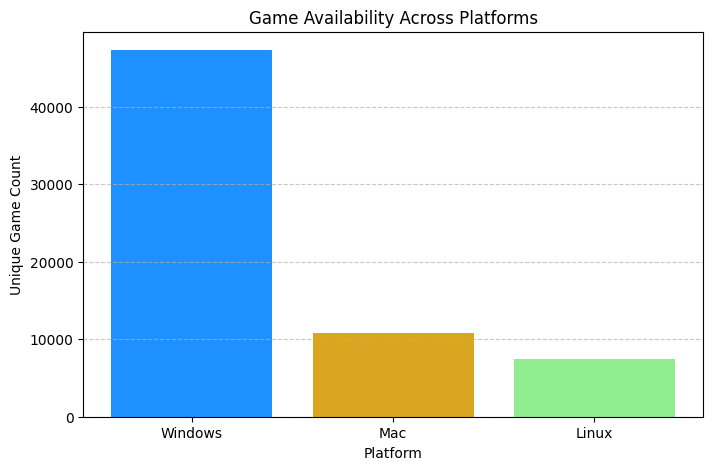

In [0]:
# Preparing visualization

import matplotlib.pyplot as plt
import pandas as pd

# Convert DataFrame to Pandas
platform_summary_pd = platform_summary_df.toPandas()

# Prepare Data for Visualization
platforms = ["Windows", "Mac", "Linux"]
game_counts = [platform_summary_pd["windows_games"][0], 
               platform_summary_pd["mac_games"][0], 
               platform_summary_pd["linux_games"][0]]

# Create Bar Chart Using Matplotlib
plt.figure(figsize=(8,5))
plt.bar(platforms, game_counts, color=["dodgerblue", "goldenrod", "lightgreen"])

# Formatting
plt.xlabel("Platform")
plt.ylabel("Unique Game Count")
plt.title("Game Availability Across Platforms")
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show the Graph
plt.show()

In [0]:
# Do certain genres tend to be preferentially available on certain platforms?

# Extract the primary genre (first element of the array)
steam_df = steam_df.withColumn("primary_genre", split(col("data.genre"), ", ").getItem(0))

genre_platform_df = steam_df.withColumn("genre", col("primary_genre"))

# Extract Platform Availability
genre_platform_df = genre_platform_df.select(
    col("id"),
    col("genre"),
    col("data.platforms.windows").cast("int").alias("windows"),
    col("data.platforms.mac").cast("int").alias("mac"),
    col("data.platforms.linux").cast("int").alias("linux")
)

# Count Unique Games Per Genre & Platform
genre_platform_count_df = genre_platform_df.groupBy("genre").agg(
    sum(col("windows")).alias("windows_count"),
    sum(col("mac")).alias("mac_count"),
    sum(col("linux")).alias("linux_count")
)

# Display Results
display(genre_platform_count_df)

genre,windows_count,mac_count,linux_count
Adventure,9975,2790,1761
Violent,133,25,16
Racing,310,34,20
Nudity,17,6,4
Indie,4837,1396,984
Strategy,787,217,113
Education,13,4,3
,75,33,25
Casual,8526,2013,1307
RPG,756,123,83
